In [15]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib
import ast
from optuna.visualization import plot_param_importances, plot_parallel_coordinate

In [16]:
def get_project_root():
    """Find project root directory containing README.md."""
    current_dir = os.path.abspath(os.getcwd())
    while not os.path.exists(os.path.join(current_dir, "README.md")):
        current_dir = os.path.dirname(current_dir)
        if current_dir == os.path.dirname(current_dir):
            raise FileNotFoundError("Could not find project root (README.md)")
    return current_dir

In [17]:
# 1. Load results dynamically
experiment_name = "v1_initial_run"  # Update as needed
results_dir = os.path.join(get_project_root(), "results", experiment_name)
results = pd.read_csv(os.path.join(results_dir, "optuna_results.csv"))

In [18]:
results.groupby("model")[["mean_test_f1", "mean_test_accuracy", 
                                 "mean_test_precision", "mean_test_recall", 
                                 "overfit"]].describe()

mean_test_f1                                          \
                        count      mean       std       min       25%   
model                                                                   
GradientBoosting         50.0  0.704540  0.009420  0.678907  0.703167   
RandomForest             50.0  0.668404  0.008561  0.640424  0.665029   
XGBoost                  50.0  0.704046  0.023716  0.542042  0.704211   

                                               mean_test_accuracy            \
                       50%       75%       max              count      mean   
model                                                                         
GradientBoosting  0.708009  0.710811  0.712603               50.0  0.871147   
RandomForest      0.670464  0.674630  0.678203               50.0  0.861047   
XGBoost           0.708735  0.710291  0.712621               50.0  0.870922   

                  ... mean_test_recall           overfit                      \
                  ...              75%       max   count      mean       std   
model             ...                                                          
GradientBoosting  ...         0.656392  0.658938    50.0  0.041380  0.032666   
RandomForest      ...         0.599363  0.607170    50.0  0.131072  0.071284   
XGBoost           ...         0.652756  0.658425    50.0  0.048150  0.045714   

                                                                    
                       min       25%       50%       75%       max  
model                                                               
GradientBoosting  0.004083  0.014027  0.041004  0.055495  0.178830  
RandomForest      0.016687  0.081262  0.147387  0.172202  0.266510  
XGBoost           0.005391  0.018724  0.023730  0.054292  0.139414  

[3 rows x 40 columns]

In [19]:
plt.rcParams["figure.figsize"] = (10, 6)

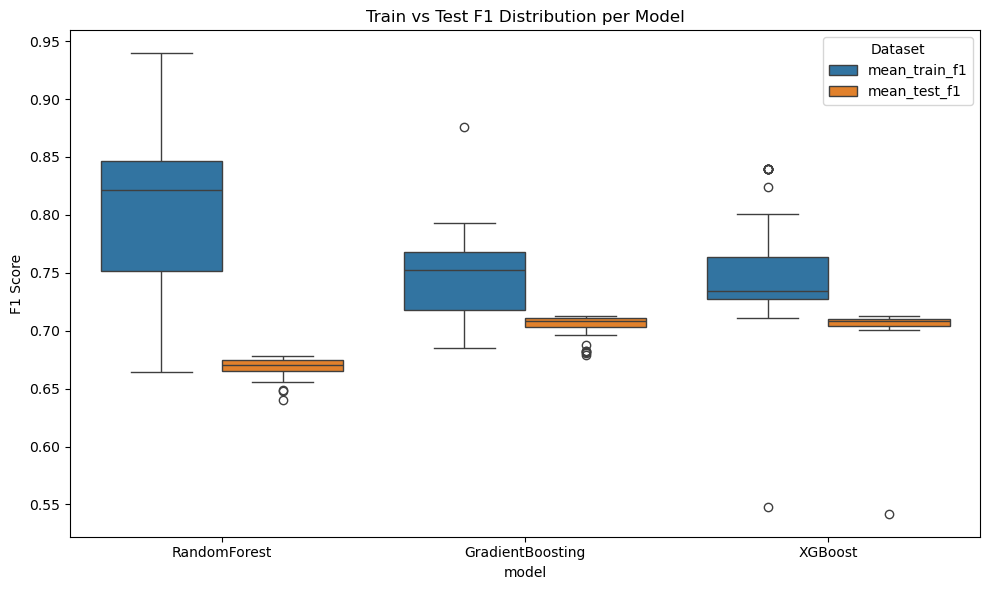

In [20]:
# Train vs Test F1 Distribution
# Do models maintain similar performance on test compared to train
plt.figure(figsize=(10, 6))
final_melt = results.melt(
    id_vars=["model"],
    value_vars=["mean_train_f1", "mean_test_f1"],
    var_name="Dataset",
    value_name="F1 Score",
)
sns.boxplot(x="model", y="F1 Score", hue="Dataset", data=final_melt)
plt.title("Train vs Test F1 Distribution per Model")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

In [ ]:
# Overfit Distribution per Model
# How much do models overfit? Which models tend to have a smaller train–test gap (more robust) vs those exceeding our overfit threshold (riskier)?
plt.figure(figsize=(8, 5))
sns.boxplot(data=results, x="model", y="overfit")
plt.axhline(0.05, color="red", linestyle="--", label="Overfit Threshold")
plt.ylabel("Train-Test F1 Gap (Overfit)")
plt.title("Overfit Distribution per Model")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
### Train vs Test F1 per Trial
# How stable is train vs test performance across trials?

models = results["model"].unique()
n_models = len(models)
fig, axes = plt.subplots(n_models, 1, figsize=(10, 4 * n_models), sharey=True)
if n_models == 1:  # handle case of only one model
    axes = [axes]
for ax, model in zip(axes, models):
    df_model = results[results["model"] == model].reset_index(drop=True)

    ax.plot(
        df_model.index,
        df_model["mean_train_f1"],
        marker="o",
        linestyle="-",
        color="tab:blue",
        alpha=0.9,
        label="Train F1",
    )
    ax.plot(
        df_model.index,
        df_model["mean_test_f1"],
        marker="x",
        linestyle="--",
        color="tab:orange",
        alpha=0.9,
        label="Test F1",
    )

    ax.set_title(f"{model}: Train vs Test F1 across Trials")
    ax.set_xlabel("Trial Index")
    ax.set_ylabel("F1 Score")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
### Scatter plot with overfit threshold line
# What’s the trade-off between performance and overfitting?
# Which models achieve high test F1 while staying below the overfit threshold
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results,
    x="mean_test_f1",
    y="overfit",
    hue="model",
    size="mean_test_accuracy",
    sizes=(50, 400),
)
plt.axhline(0.05, color="red", linestyle="--", label="Overfit Threshold")
plt.axhspan(0, 0.05, color="green", alpha=0.1, label="Safe Zone")
plt.xlabel("Test F1")
plt.ylabel("Train-Test F1 Gap (Overfit)")
plt.title("Overfit vs Test Performance")
plt.tight_layout()
plt.show()